In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os

base_dir = "/content/drive/MyDrive/graph_ai_studio/country_graph_demo"

print("Project folder:")
!ls "$base_dir"

print("\nLand data:")
!ls "$base_dir/data/land"

print("\nSea data:")
!ls "$base_dir/data/sea"


Project folder:
data  notebooks  outputs

Land data:
ne_10m_admin_0_countries.cpg	      ne_10m_admin_0_countries.shp
ne_10m_admin_0_countries.dbf	      ne_10m_admin_0_countries.shx
ne_10m_admin_0_countries.prj	      ne_10m_admin_0_countries.VERSION.txt
ne_10m_admin_0_countries.README.html

Sea data:
eez_boundaries_v12.gpkg  eez_v12.gpkg  LICENSE_EEZ_v12.txt


In [3]:
!pip install geopandas shapely pyproj pyogrio rtree --quiet


In [4]:
import geopandas as gpd

land_path = base_dir + "/data/land/ne_10m_admin_0_countries.shp"
land = gpd.read_file(land_path)

print("Land rows:", len(land))
print("Land CRS:", land.crs)
print(land[["ADMIN", "ISO_A3"]].head())


Land rows: 258
Land CRS: EPSG:4326
       ADMIN ISO_A3
0  Indonesia    IDN
1   Malaysia    MYS
2      Chile    CHL
3    Bolivia    BOL
4       Peru    PER


<Axes: >

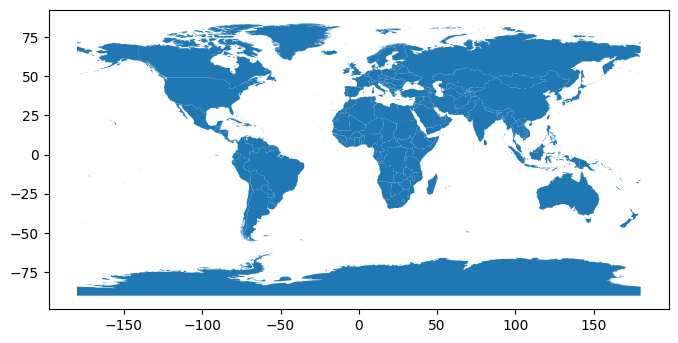

In [5]:
land.plot(figsize=(8, 4))


In [6]:
eez_path = base_dir + "/data/sea/eez_v12.gpkg"
eez = gpd.read_file(eez_path)

print("EEZ rows:", len(eez))
print("EEZ CRS:", eez.crs)
print(eez[["GEONAME", "ISO_TER1"]].head())


EEZ rows: 285
EEZ CRS: EPSG:4326
                                             GEONAME ISO_TER1
0  United States Exclusive Economic Zone (America...      ASM
1        British Exclusive Economic Zone (Ascension)      SHN
2  New Zealand Exclusive Economic Zone (Cook Isla...      COK
3  Overlapping claim Falkland / Malvinas Islands:...      FLK
4  French Exclusive Economic Zone (French Polynesia)      PYF


<Axes: >

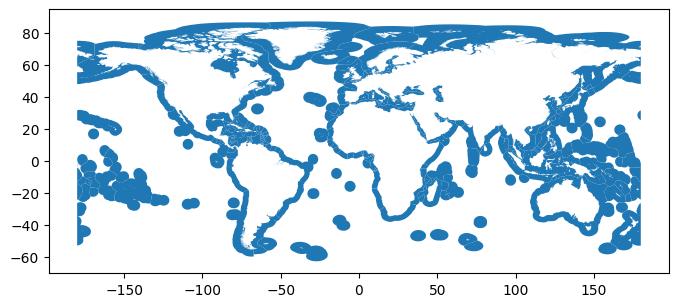

In [7]:
eez.plot(figsize=(8, 4))


In [8]:
print("Land CRS:", land.crs)
print("EEZ CRS:", eez.crs)


Land CRS: EPSG:4326
EEZ CRS: EPSG:4326


In [9]:
import pandas as pd

def build_land_edges(land_gdf, country_col="ISO_A3"):
    """
    Return list of (country1, country2, 'land') for countries sharing a land border.
    """
    gdf = land_gdf[[country_col, "geometry"]].copy()

    # Drop missing / invalid codes (Natural Earth uses -99 for non-countries)
    gdf = gdf[gdf[country_col].notna()]
    gdf = gdf[gdf[country_col] != "-99"].reset_index(drop=True)

    # Spatial index for speed
    sindex = gdf.sindex

    edges = set()

    for i, row in gdf.iterrows():
        geom_i = row.geometry
        if geom_i is None or geom_i.is_empty:
            continue

        c_i = row[country_col]

        # Candidates whose bbox intersects this one
        possible_matches_idx = list(sindex.intersection(geom_i.bounds))

        for j in possible_matches_idx:
            if j <= i:
                continue  # avoid self + duplicates

            row_j = gdf.iloc[j]
            geom_j = row_j.geometry
            if geom_j is None or geom_j.is_empty:
                continue

            c_j = row_j[country_col]

            # Touch along boundary = land border
            if geom_i.touches(geom_j):
                edge = tuple(sorted((c_i, c_j)))
                edges.add(edge)

    return [(c1, c2, "land") for (c1, c2) in sorted(edges)]


land_edges = build_land_edges(land)
print("Number of land edges:", len(land_edges))
land_edges[:10]


Number of land edges: 306


[('AFG', 'CHN', 'land'),
 ('AFG', 'IRN', 'land'),
 ('AFG', 'PAK', 'land'),
 ('AFG', 'TJK', 'land'),
 ('AFG', 'TKM', 'land'),
 ('AFG', 'UZB', 'land'),
 ('AGO', 'COD', 'land'),
 ('AGO', 'COG', 'land'),
 ('AGO', 'NAM', 'land'),
 ('AGO', 'ZMB', 'land')]

In [13]:
def build_sea_edges(eez_gdf, country_col="ISO_TER1"):
    """
    Return list of (country1, country2, 'sea') for countries whose EEZ polygons touch.
    """
    gdf = eez_gdf[[country_col, "geometry"]].copy()

    # Keep only rows with a country code
    gdf = gdf[gdf[country_col].notna()].reset_index(drop=True)

    # Spatial index
    sindex = gdf.sindex

    edges = set()

    for i, row in gdf.iterrows():
        geom_i = row.geometry
        if geom_i is None or geom_i.is_empty:
            continue

        c_i = row[country_col]

        possible_matches_idx = list(sindex.intersection(geom_i.bounds))

        for j in possible_matches_idx:
            if j <= i:
                continue  # avoid duplicates

            row_j = gdf.iloc[j]
            geom_j = row_j.geometry
            if geom_j is None or geom_j.is_empty:
                continue

            c_j = row_j[country_col]

            # Skip if same country (EEZ may have multiple parts)
            if c_i == c_j:
                continue

            if geom_i.touches(geom_j):
                edge = tuple(sorted((c_i, c_j)))
                edges.add(edge)

    return [(c1, c2, "sea") for (c1, c2) in sorted(edges)]


sea_edges = build_sea_edges(eez, country_col="ISO_TER1")
print("Number of sea edges:", len(sea_edges))
sea_edges[:10]


Number of sea edges: 238


[('ABW', 'CUW', 'sea'),
 ('ABW', 'VEN', 'sea'),
 ('AGO', 'COD', 'sea'),
 ('AGO', 'COG', 'sea'),
 ('AGO', 'NAM', 'sea'),
 ('AIA', 'ATG', 'sea'),
 ('AIA', 'BES', 'sea'),
 ('AIA', 'BLM', 'sea'),
 ('AIA', 'MAF', 'sea'),
 ('AIA', 'VGB', 'sea')]

In [14]:
# Combine land + sea edges into one table
all_edges = land_edges + sea_edges

edges_df = pd.DataFrame(all_edges, columns=["node1", "node2", "how"])
print(edges_df.head())
print("Total edges (land + sea):", len(edges_df))

# Save to outputs
output_path = base_dir + "/outputs/country_edges_land_sea.csv"
edges_df.to_csv(output_path, index=False)
print("Saved edge list to:", output_path)


  node1 node2   how
0   AFG   CHN  land
1   AFG   IRN  land
2   AFG   PAK  land
3   AFG   TJK  land
4   AFG   TKM  land
Total edges (land + sea): 544
Saved edge list to: /content/drive/MyDrive/graph_ai_studio/country_graph_demo/outputs/country_edges_land_sea.csv
